### Case Study: Credit Underwriting and Analysis

A credit company acquires applicants for credit. These applicants apply for credit, and the company decides whether to issue credit.

Using historical data, the business wants to build model that can predict whether an applicant will default, and understand which applicant characteristics drive loan performance.

### Goals:

* Build a predictive classifier. Defaults are both rare and expensive, we prefer a model that has a high recall on the default class.
* Be able to explain why an applicant was approved or denied, in the event that they ask for clarification.
* Uncover which types of applicants the firm should market to.

### Load the data
We are going to perform our analysis on data from LendingClub. Data is available here:

https://www.lendingclub.com/info/download-data.action



In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import pandas as pd
import numpy as np

df = pd.read_csv('LoanStats3a.csv', skiprows=1)
df = df[df.loan_status.isin(['Fully Paid','Charged Off'])]

#remove columns that are entirely null
for column in df.columns:
    if df[column].isnull().mean() >= .99:
        df = df.drop(column, 1)
        
        
#remove columns with constant values
for column in df.columns:
    if df[column].unique().shape[0] == 1:
        df = df.drop(column, 1)        

In [2]:
print("The data has {0} rows and {1} fields".format(*df.shape))

The data has 39786 rows and 45 fields


In [3]:
df.head().T

,0,1,2,3,4
loan_amnt,5000,2500,2400,10000,3000
funded_amnt,5000,2500,2400,10000,3000
funded_amnt_inv,4975,2500,2400,10000,3000
term,36 months,60 months,36 months,36 months,60 months
int_rate,10.65%,15.27%,15.96%,13.49%,12.69%
installment,162.87,59.83,84.33,339.31,67.79
grade,B,C,C,C,B
sub_grade,B2,C4,C5,C1,B5
emp_title,NaN,Ryder,NaN,AIR RESOURCES BOARD,University Medical Group
emp_length,10+ years,< 1 year,10+ years,10+ years,1 year


We want to model loan performance **before** a loan is originated; therefore we should be careful to exclude any information that becomes available **after** the issued, such as recoveries, principle paid, etc.

### Utilities

We are going to define some helper functions for data exploration and model validation.

In [32]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize


def def_rates_by_categorical(column, 
                             with_variance=False, 
                             sort=True):
    """"""
    grouped = df.groupby([column,'loan_status'])
    def_counts = grouped['loan_amnt'].count().unstack()
    N = def_counts.sum(axis=1)
    props = def_counts['Charged Off'] / N
    if sort:
        props = props.sort_values()
    var = ((props * (1 - props)) / N) ** (.5)
    if with_variance:
        ax = props.plot(kind = 'bar', yerr = var)
    else:
        ax = props.plot(kind = 'bar')
    ax.set_ylabel("Default Rate (0-1)")
    ax.set_title("Default Rates by {}".format(column))
    ax.set_xlabel(column)
    return ax
    
def round_to_nearest(x, base=1):
    return base * int(x / base)

def plot_roc_curve(y_test, X_test, model_dict):
    y_test_ = label_binarize(y_test, classes=[0, 1, 2])[:, :2]
    preds = {}
    fpr = {}
    tpr = {}
    roc_auc = {}
    f, ax = plt.subplots(1)
    
    #plt.figure()
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    
    plot_data = {}
    
    for model_key in model_dict:
        preds = model_dict[model_key].predict_proba(X_test)
        fpr = {}
        tpr = {} 
        roc_auc = {}        
        
        for i in range(2):
            fpr[i], tpr[i], _ = roc_curve(y_test_[:, i], preds[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_.ravel(), preds.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        name = "%s: (AUC = %0.2f)" % (model_key, roc_auc[1])
        plot_data = pd.DataFrame(tpr[1], index=fpr[1], columns = [name])
        plot_data.plot(ax=ax)
    plt.show()
    return ax


def classifaction_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = re.split('[ ]+', line)
        row['class'] = row_data[1]
        row['precision'] = float(row_data[2])
        row['recall'] = float(row_data[3])
        row['f1_score'] = float(row_data[4])
        row['support'] = float(row_data[5])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)
    return dataframe

def hover(hover_color="#ffff99"):
    return dict(selector="tr:hover",
                props=[("background-color", "%s" % hover_color)])

styles = [
    hover(),
    dict(selector="th", props=[("font-size", "100%"),
                               ("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    

def plot_discriminative_thresholds(model, y_true, include_f1=True):
    probabilities = model.predict_proba(X_test)
    prec = {}
    rec = {}
    f1_scores = {}
    for i in map(lambda x: x / 20., range(20)):
        predictions = np.apply_along_axis(lambda x: x[1] > i, 1, probabilities)
        precision, recall, f1, support = precision_recall_fscore_support(y_test, predictions)
        prec[i] = precision[1]
        rec[i] = recall[1]
        f1_scores[i] = f1[1]
        
    best_i = pd.Series(f1_scores).idxmax()


    default_thresholds = pd.DataFrame({'recall':pd.Series(rec), 
                                       'precision':pd.Series(prec),
                                       'f1':pd.Series(f1_scores)})
    if include_f1:
        ax = default_thresholds.plot()
    else:
        ax = default_thresholds[['recall','precision']].plot()
    ax.axvline(best_i, linestyle= "--", color = 'gray')
    ax.text(1.1, .6, "F1 Optimal Threshold: %.2f" % best_i)
    ax.text(1.1, .52, "Optimal Recall: %.2f" % rec[best_i])
    ax.text(1.1, .44, "Optimal Precision: %.2f" % prec[best_i])
    ax.set_xlabel('Discriminative Threshold')
    return ax


def cv_to_df(cv):
    cv_results = pd.DataFrame(list(cv['params']))
    for col in ['split2_test_score', 'split1_test_score', 'split0_test_score', 'mean_test_score','std_test_score', 'mean_train_score']:
        cv_results[col] = cv[col]

    cv_results['sharpe'] = cv_results['mean_test_score'] / cv_results['std_test_score']
    cv_results['testing_over_training'] = cv_results['mean_test_score'] / cv_results['mean_train_score']    
    cv_results = cv_results.sort_values('sharpe')
    return cv_results

### Preprocessing

In [5]:
re_not_decimal = re.compile(r'[^\.0-9]*')

def process_int_rate(x):
    x = x.strip()
    x = re_not_decimal.sub("", x)    
    return float(x)

def process_revol_util(x):
    if pd.isnull(x):
        return 0
    else:
        x = x.strip()
        x = re_not_decimal.sub("", x)    
        return float(x)

def process_term(x):
    x = re_not_decimal.sub("", x)
    return int(x)

def process_emp_length(x):
    x = re_not_decimal.sub("", x)
    if x == '':
        return np.nan
    else:
        return float(x)
    


df['int_rate'] = df['int_rate'].apply(process_int_rate)
df['term'] = df['term'].apply(process_term)
df['emp_length'] = df['emp_length'].apply(process_emp_length)
df['revol_util'] = df['revol_util'].apply(process_revol_util)
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)

### Distribution of credit outcomes

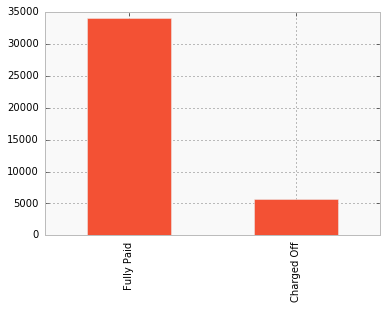

In [6]:
%matplotlib inline
df.loan_status.value_counts().plot(kind='bar')

### Lower grade credit related to default rates

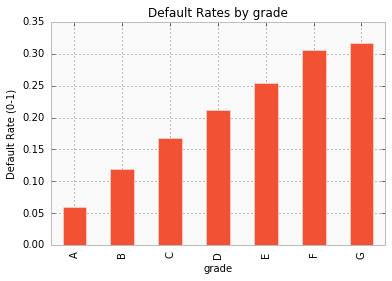

In [7]:
def_rates_by_categorical('grade')

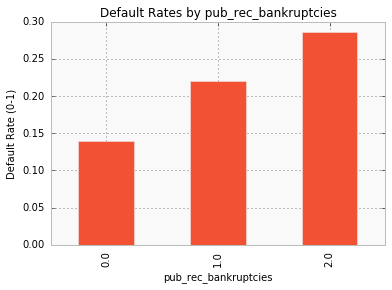

In [8]:
ax = def_rates_by_categorical('pub_rec_bankruptcies')

In [9]:
# from matplotlib import pyplot as plt
# import math

# default = df_[df_['default'].apply(bool)]
# nodefault = df_[df_.default.apply(bool)==False]
# features = others['param'].values
# n_features = features.shape[0]
# rows = int(math.ceil(n_features / 4))
# cols = 4
# f, axes = plt.subplots(nrows=rows, ncols=cols, figsize = (16, 15))
# for i, row in enumerate(axes):
#     for j, ax in enumerate(row):
#         idx = 4 * i + j
#         if idx <= n_features:
#             column = features[idx]
#             ax.violinplot([default[column], nodefault[column]], positions = [0,1])
#             ax.set_xlabel(column)
            
        
    

### DTI also a factor

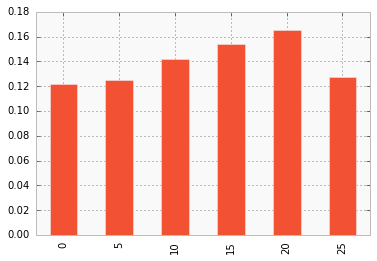

In [9]:
def_by_dti = df.set_index('dti').groupby(by=(lambda x: round_to_nearest(x, 5), 'loan_status'))['loan_amnt'].count().unstack()
def_by_dti = (def_by_dti['Charged Off'] / def_by_dti.sum(axis=1))
ax = def_by_dti.plot(kind = 'bar')

### Not what we'd expect from verification status

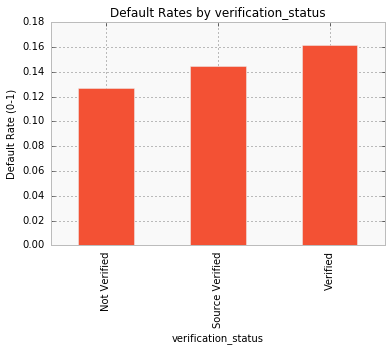

In [10]:
ax = def_rates_by_categorical('verification_status')

### Small business loans are much riskier

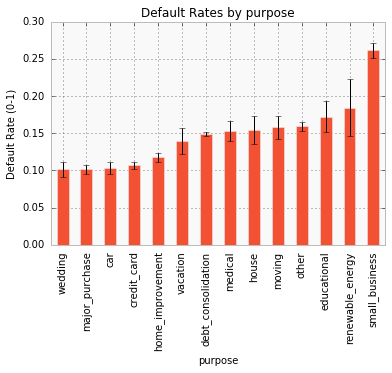

In [11]:
def_rates_by_categorical('purpose', with_variance=True)

### (Light) Feature Engineering

In [12]:
df_ = df.copy()

domain_columns = ['loan_amnt', 
                  'term', 
                  'annual_inc', 
                  'installment_over_income', 
                  'has_employer_info',
                  'is_employed',
                  'dti',
                  'purpose_is_small_business',
                  'inq_last_6mths',
                  'delinq_2yrs',
                  'open_acc',
                  'int_rate',
                  'revol_util',
                  'pub_rec_bankruptcies',
                  'revol_bal',
                  'requested_minus_funded',
                  'debt_to_income'
                 ]

#features to engineer
df_['requested_minus_funded'] = df_['loan_amnt'] - df_['funded_amnt']
df_['has_employer_info'] = df_['emp_title'].isnull()
df_['installment_over_income'] = df_['installment'] / df_['annual_inc']
df_['is_employed'] = df_['emp_length'].isnull()
df_['debt_to_income'] = (df_['revol_bal'] + df_['funded_amnt']) / df['annual_inc']



#dummy section
dummy_columns = ['home_ownership','purpose', 'grade', 'addr_state']

for column in dummy_columns:
    dummies = pd.get_dummies(df_[column], prefix="{}_is".format(column))
    columns_to_add = dummies.columns.values[:-1]
    dummies = dummies[columns_to_add]
    df_ = df_.join(dummies)
    domain_columns.extend(columns_to_add)

df_['default'] = df_['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
domain_columns = list(set(domain_columns))



### Train/Test Split

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(df_[domain_columns].values)
y = df_['default'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size = .2)

### Train a Logistic Regression

We'll first try out a logistic regression. If the model is performant, explaining its behavior for a given decision, and describing broader relationships between applicant characteristics and default risk is trivial; we can exactly express the model with a few coefficients.

In [14]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()
reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Lets evaluate how well our regression did:

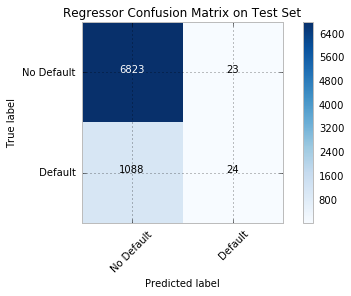

In [15]:
cm = confusion_matrix(y_test, reg.predict(X_test))
plt.figure()
plot_confusion_matrix(cm, classes=['No Default',' Default'],
                      normalize=False,
                      title='Regressor Confusion Matrix on Test Set')

* **Low discriminating power / "Naive Classifier"**
* **Apparent class imbalance problem**
* **need to reweight or resample**

Our regression was not able to discriminate between defaulting and non-defaulting applicants, and appears to be a "Naive" classifier in the sense that simply predicts the majority class. Let's try again, increasing the weight of the minority class:

In [16]:
balanced_reg = LogisticRegression(class_weight='balanced')
balanced_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

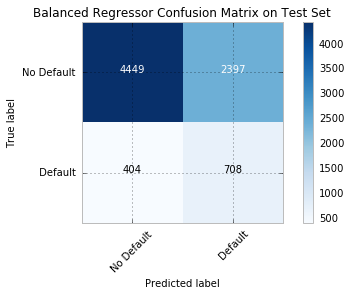

In [17]:
cm = confusion_matrix(y_test, balanced_reg.predict(X_test))
plt.figure()
plot_confusion_matrix(cm, classes=['No Default',' Default'],
                      normalize=False,
                      title='Balanced Regressor Confusion Matrix on Test Set')

Naturally, the recall of the defaulted has increased; most loans that Default are predicted as such. However, the precision is very low; most predictions of "Default" will be incorrect. At this point, the researcher must determine the relative costs of false positives and false negatives, and adjust a discriminative threshold accordingly. To help us understand this, we'll vary the threshold to see how well we do on the "Default" class.

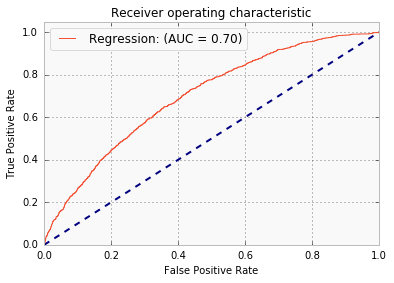

In [18]:
ax = plot_roc_curve(y_test, X_test, {'Regression': balanced_reg})

* Beginning to get good results
* Begin looking at features

In [19]:
linear_coefs = pd.DataFrame({'value':balanced_reg.coef_[0],
                             'param':domain_columns}).sort_values('value')

is_state = lambda x: bool(re.match('addr_state', x))
is_grade = lambda x: bool(re.match('grade_is', x))
is_other = lambda x: not(is_state(x) or is_grade(x))


states = linear_coefs[linear_coefs['param'].apply(is_state)]
grades = linear_coefs[linear_coefs['param'].apply(is_grade)]
others = linear_coefs[linear_coefs['param'].apply(is_other)]

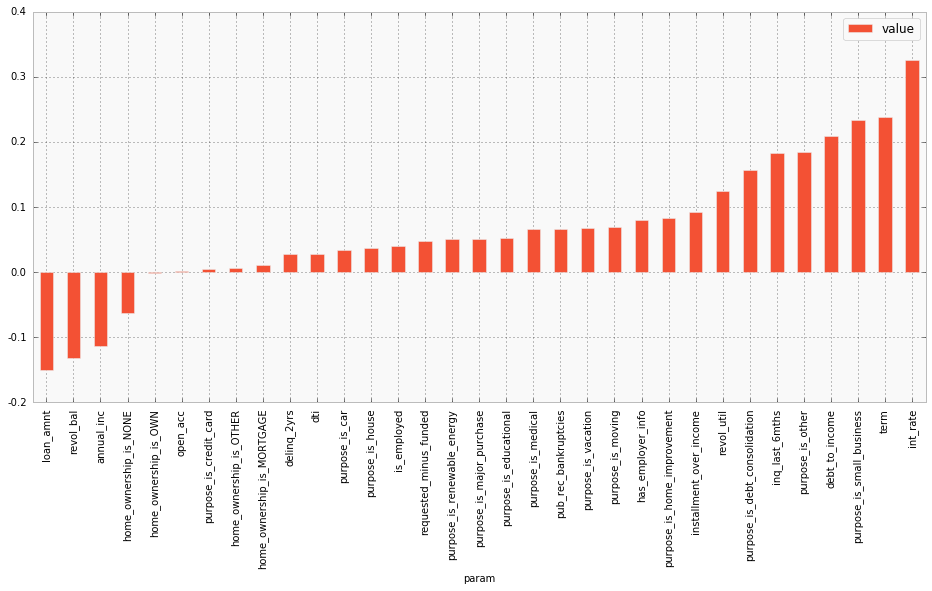

In [20]:
f, ax = plt.subplots(1, figsize=(16, 7))
others.set_index('param').plot(ax=ax,kind = 'bar')


### What the regression has learned:
* Factors that contribute to default:
    * long term loans
    * high interest rates
    * applicant liquidity/solvency
    * no history of bad behavior
* These all seem reasonable.

* A linear model could be suboptimal if:
    * There is a nonlinear relationship between a variable and the target
    * If there is an interaction between two variables and the target

### Train a feed forward NN

Were going to do some grid search over the number of layers.

In [21]:
import sys
if 'keras' not in sys.modules:
    !sudo pip install keras

import os
os.environ['KERAS_BACKEND'] = 'theano'

from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers


def create_nn(layer_size, 
              l2_weight, 
              dropout_prob,
              layer_size2, 
              l2_weight2, 
              dropout_prob2):
    
    input_layer = Dense(X.shape[1], 
                    input_dim=X.shape[1], 
                    kernel_initializer='normal', 
                    activation='relu')
    
    hidden_layer1 = Dense(layer_size, 
                    kernel_initializer='normal', 
                    activation='relu',
                    kernel_regularizer=regularizers.l2(l2_weight), 
                   )
    
    dropout1 = Dropout(dropout_prob)
    
    hidden_layer2 = Dense(layer_size2, 
                    input_dim=layer_size,
                    kernel_initializer='normal', 
                    activation='relu',
                    kernel_regularizer=regularizers.l2(l2_weight2), 
                   )
    
    dropout_layer2 = Dropout(dropout_prob2)
    
    output_layer = Dense(1, kernel_initializer='normal', activation='sigmoid')
    
    
    
    # create model
    model = Sequential()
    model.add(input_layer)
    model.add(hidden_layer1)
    model.add(dropout1)
    model.add(hidden_layer2)
    model.add(dropout_layer2)    
    model.add(output_layer)
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
    return model
    
class_weights = {0: y_train.mean(), 1: 1 - y_train.mean()}

class NNPipeline(Pipeline):
    """Inherits sklearn's Pipeline, with keyword args"""
    
    def __init__(self, layer_size=10, n_epochs=None, dropout_prob=.1, l2_weight=.01, layer_size2=10, dropout_prob2=.1, l2_weight2=.01):
        
        if n_epochs is None:
            n_epochs = 10
        
        def nn_func():
            #create a parameter free generator
            return create_nn(layer_size, 
                             l2_weight, 
                             dropout_prob, 
                             layer_size2, 
                             l2_weight2, 
                             dropout_prob2)
        
        self.layer_size = layer_size
        self.n_epochs = n_epochs
        self.l2_weight = l2_weight
        self.dropout_prob = dropout_prob
        self.layer_size2 = layer_size2
        self.dropout_prob2 = dropout_prob2
        self.l2_weight2 = l2_weight2
        
        nn_estimators = []
        nn_estimators.append(('mlp', KerasClassifier(build_fn=nn_func, 
                                                  epochs=n_epochs, 
                                                  batch_size=5000, 
                                                  verbose=4,
                                                  class_weight = class_weights
                                                 )))        
        
        super(NNPipeline,self).__init__(nn_estimators)
        

You are using pip version 7.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using Theano backend.


In [84]:
from sklearn.model_selection import GridSearchCV
parameters = {'layer_size':   [35, 55, 75], 
              'dropout_prob': [.01, .1, .2], 
              'l2_weight':    [.001, .01],
              'layer_size2':  [10, 35, 55], 
              'dropout_prob2':[.01, .1, .2], 
              'l2_weight2': [.001, .01]
             }
gsnn = GridSearchCV(NNPipeline(), parameters)
gsnn.fit(X_train, y_train)

INFO (theano.gof.compilelock): Refreshing lock /home/deploy/.theano/compiledir_Linux-3.13--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/deploy/.theano/compiledir_Linux-3.13--generic-x86_64-with-Ubuntu-14.04-trusty-x86_64-2.7.6-64/lock_dir/lock


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
E

GridSearchCV(cv=None, error_score='raise',
       estimator=NNPipeline(dropout_prob=0.1, dropout_prob2=0.1, l2_weight=0.01,
      l2_weight2=0.01, layer_size=10, layer_size2=10, n_epochs=10),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'layer_size2': [10, 35, 55], 'l2_weight2': [0.001, 0.01], 'dropout_prob': [0.01, 0.1, 0.2], 'l2_weight': [0.001, 0.01], 'dropout_prob2': [0.01, 0.1, 0.2], 'layer_size': [35, 55, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [124]:
## evaluation cross val tuning results
## a good model will consistently do well
## on test tests, expected val accu / val accuracy variance

cv_results = pd.DataFrame(list(gsnn.cv_results_['params']))
for col in ['split2_test_score', 'split1_test_score', 'split0_test_score', 'mean_test_score','std_test_score']:
    cv_results[col] = gsnn.cv_results_[col]
    
cv_results['sharpe'] = cv_results['mean_test_score'] / cv_results['std_test_score']
cv_results = cv_results.sort_values('sharpe')
best = cv_results[gsnn.best_params_.keys()].iloc[0]

In [136]:
print best.to_dict()

{'layer_size2': 55.0, 'l2_weight2': 0.01, 'dropout_prob': 0.10000000000000001, 'l2_weight': 0.001, 'dropout_prob2': 0.20000000000000001, 'layer_size': 55.0}


In [23]:
from keras import callbacks
params = {'dropout_prob': 0.10000000000000001,
         'dropout_prob2': 0.20000000000000001,
         'l2_weight': 0.001,
         'l2_weight2': 0.01,
         'layer_size': 55,
         'layer_size2': 55}

def nn_func():
    return create_nn(**params)
    

nn = KerasClassifier(build_fn=nn_func, 
                     epochs=100, 
                     batch_size=5000, 
                     verbose=0,
                     callbacks = [callbacks.History(),
                                  callbacks.EarlyStopping(monitor='val_acc', patience=30)],
                     class_weight = class_weights)

history = nn.fit(X_train, y_train, validation_data=(X_validate, y_validate))

### Lets also train a rf

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
parameters = {"max_depth": [10, None],
              "max_features": [5, None, 'auto'],
             'min_samples_leaf':[2, .001]}

rf = GridSearchCV(RandomForestClassifier(n_estimators = 100, 
                                               class_weight='balanced'), 
                        parameters, 
                        n_jobs = 4)
rf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_features': [5, None, 'auto'], 'max_depth': [10, None], 'min_samples_leaf': [2, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [34]:
cv_to_df(rf.cv_results_).iloc[-1].to_dict()

{'max_depth': nan,
 'max_features': None,
 'mean_test_score': 0.85362500981855316,
 'mean_train_score': 0.99992145311705682,
 'min_samples_leaf': 2.0,
 'sharpe': 2786.1626161967588,
 'split0_test_score': 0.8535579641847314,
 'split1_test_score': 0.85402921771913287,
 'split2_test_score': 0.85328776808861651,
 'std_test_score': 0.00030638018213875501,
 'testing_over_training': 0.8536920646692262}

In [30]:
picked_params = {'max_depth': 10.0,
             'max_features': None,
             'min_samples_leaf': 0.001,}


rf_params = rf.best_estimator_.get_params()
rf_params.update(picked_params)
rf_params['n_estimators'] = 300

rf_best = RandomForestClassifier(**rf_params)
rf_best.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10.0, max_features=None,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=0.001, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

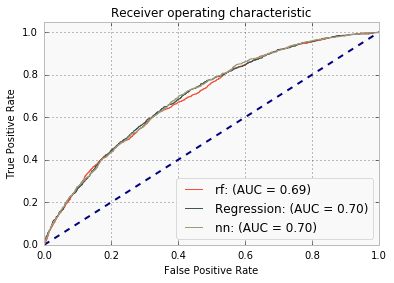

In [31]:
ax = plot_roc_curve(y_test, X_test, {'Regression': balanced_reg, 'nn':nn, 'rf':rf_best})

### Why are these more sophistocated models not doing better?

Lets use skater to explore our models. Recall:

* A linear model could be suboptimal if:
    * There is a nonlinear relationship between a variable and the target
    * If there is an interaction between two variables and the target
    
    
Lets begin looking for a non-linearity or an interaction. Where to start our search? Lets run feature importance to check.

In [38]:
from skater import Interpretation
from skater.model import InMemoryModel

model_nn = InMemoryModel(nn.predict_proba, target_names=['Paid off',' Default'], examples=X_train[:5])
model_reg = InMemoryModel(balanced_reg.predict_proba, target_names=['Paid off',' Default'], examples=X_train[:5])
model_rf = InMemoryModel(rf_best.predict_proba, target_names=['Paid off',' Default'], examples=X_train[:5])

interpreter = Interpretation(X_train, feature_names=domain_columns)


### Feature importance (top 20)

In [39]:
reg_importances = interpreter.feature_importance.feature_importance(model_reg)
rf_importances = interpreter.feature_importance.feature_importance(model_rf)
nn_importances = interpreter.feature_importance.feature_importance(model_nn)

<IPython.core.display.Javascript object>


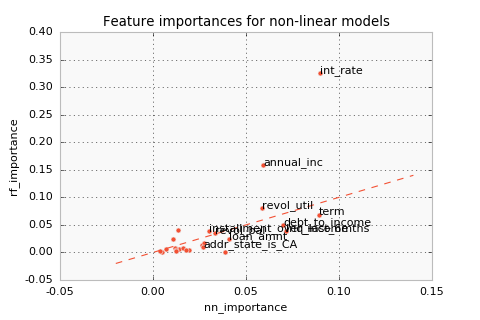

In [50]:
%matplotlib notebook
importances = pd.DataFrame({'nn_importance':nn_importances,
 'rf_importance':rf_importances,
 'reg_importance':reg_importances}
 )

importances['mean'] = importances.mean(axis=1)
importances = importances.sort_values('mean').reset_index().tail(25)
x = 'nn_importance'
y = 'rf_importance'
val = 'index'

ax = importances.plot(kind = 'scatter', x = x, y = y)

        
for i, point in importances.tail(10).iterrows():
    ax.text(point[x], point[y], str(point[val]))
    
ax.set_title("Feature importances for non-linear models")
ax.plot(ax.get_xticks(), ax.get_xticks(), linestyle = "--")

Most relevant features:
* interest rate
* annual income
* credit utilization
* term
* debt to income

<IPython.core.display.Javascript object>


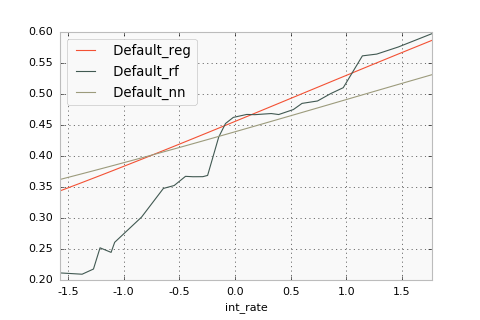

<IPython.core.display.Javascript object>


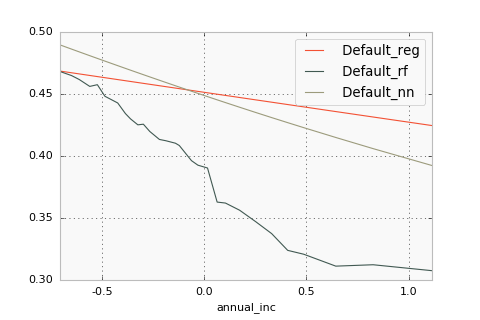

<IPython.core.display.Javascript object>


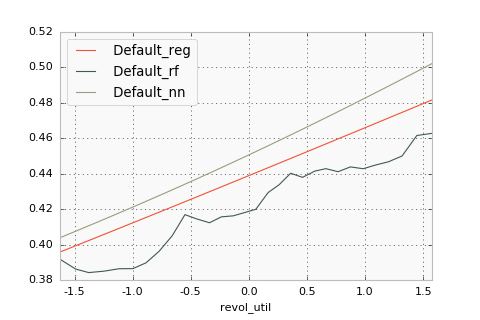

<IPython.core.display.Javascript object>


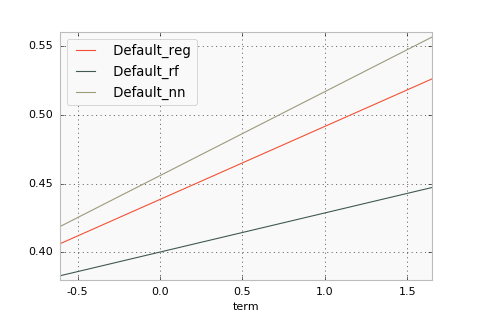

<IPython.core.display.Javascript object>


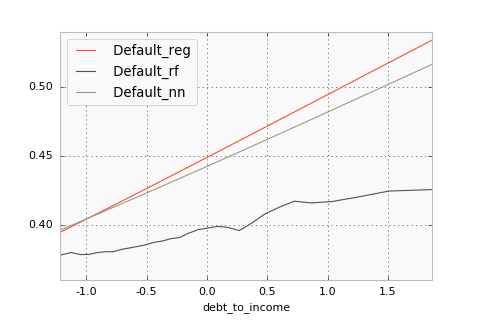

In [52]:
features = ['int_rate','annual_inc','revol_util','term','debt_to_income']
models = {'nn':nn, 'rf':rf_best, 'reg':balanced_reg}


for feature in features:
    pd_rf = interpreter.partial_dependence.partial_dependence([feature], model_rf, n_samples=500).set_index(feature)
    pd_reg = interpreter.partial_dependence.partial_dependence([feature], model_reg, n_samples=500).set_index(feature)
    pd_nn = interpreter.partial_dependence.partial_dependence([feature], model_nn, n_samples=500).set_index(feature)
    
    pd_rf.columns = [i + "_rf" for i in pd_rf.columns]
    pd_reg.columns = [i + "_reg" for i in pd_reg.columns]
    pd_nn.columns = [i + "_nn" for i in pd_nn.columns]
    
    
    pd_reg.join(pd_rf).join(pd_nn)[[' Default_reg',' Default_rf', ' Default_nn']].plot()

It looks like all the models learned approximately linear relationships among the top features! Lets check a couple features for interactions.

<IPython.core.display.Javascript object>


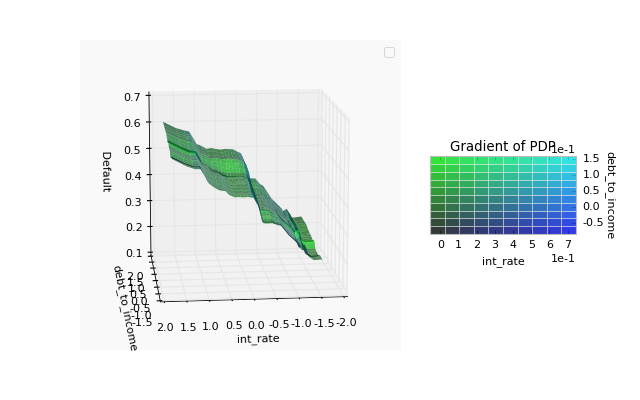

[[<matplotlib.figure.Figure at 0x7f2a1cf72990>,

In [53]:
interpreter.partial_dependence.plot_partial_dependence([('int_rate', 'debt_to_income')], 
                                                      model_rf, 
                                                      n_samples=500, figsize=(8, 5))

<IPython.core.display.Javascript object>


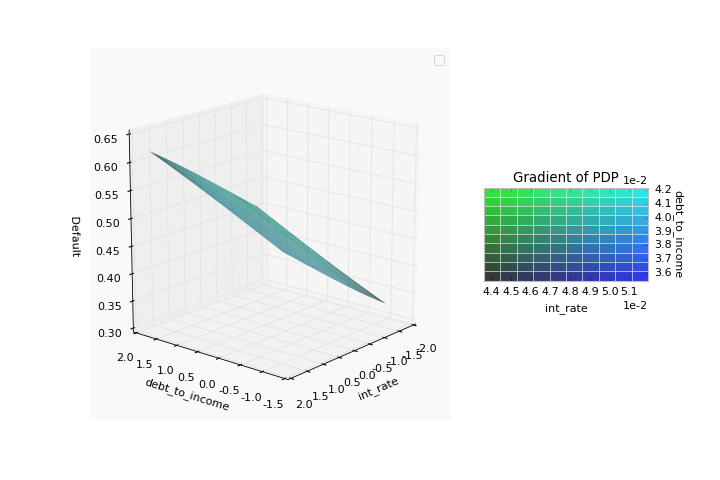

[[<matplotlib.figure.Figure at 0x7f2a1c26ed50>,

In [56]:
interpreter.partial_dependence.plot_partial_dependence([('int_rate', 'debt_to_income')], 
                                                      model_nn, 
                                                      n_samples=500, figsize = (9, 6))

It looks as if the more complex models arent much more than learning what the regression learned!